In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten, Dropout, BatchNormalization, LayerNormalization, TimeDistributed
#from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
import tensorflow as tf
#import talib as ta
from keras import regularizers
from sklearn.metrics import mean_squared_error
#import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sklearn
#from keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GBP_USD_M15.csv')
df.head()

,Unnamed: 0,datetime,open,high,low,close,volume
0,0,2005-01-02T19:15:00.000000000Z,1.9193,1.9193,1.9193,1.9193,1
1,1,2005-01-02T19:30:00.000000000Z,1.9188,1.9197,1.9188,1.9194,11
2,2,2005-01-02T20:00:00.000000000Z,1.9191,1.9197,1.9191,1.9197,2
3,3,2005-01-02T20:30:00.000000000Z,1.9193,1.9197,1.9193,1.9197,2
4,4,2005-01-02T20:45:00.000000000Z,1.9197,1.9197,1.9185,1.9194,36


In [4]:
!python --version    # more help to install taLib  https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib as ta

Python 3.7.13
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3981    0  3981    0     0  16726      0 --:--:-- --:--:-- --:--:-- 16726
100  503k  100  503k    0     0   630k      0 --:--:-- --:--:-- --:--:-- 5127k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3949    0  3949    0     0  18715      0 --:--:-- --:--:-- --:--:-- 18715
100  406k  100  406k    0     0   503k      0 --:--:-- --:--:-- --:--:-- 2863k


In [7]:
def addIndicators(df):

    df['RSI5'] = ta.RSI(df['close'], timeperiod=5)
    df['RSI10'] = ta.RSI(df['close'], timeperiod=10)
    df['RSI20'] = ta.RSI(df['close'], timeperiod=20)

    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], \
                                                                 fastperiod=12, slowperiod=26, signalperiod=9)

    df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], \
                                            df['close'], fastk_period=5, slowk_period=3, slowk_matype=0,
                                            slowd_period=3, slowd_matype=0)
    df['fastk'], df['fastd'] = ta.STOCHF(df['high'], df['low'], \
                                             df['close'], fastk_period=5, fastd_period=3, fastd_matype=0)

    df['WR5'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=5)
    df['WR10'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=10)
    df['WR20'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=20)

    df['TRANGE'] = ta.TRANGE(df['high'], df['low'], df['close'])
    return df
df = addIndicators(df)

In [8]:
### Generating price sequence in multidimensions
num_days=5
def price_sequence2d(data,price,num_days):
    X, y = [], []
    for i in range(len(price)-num_days):
        y.append(price[i+num_days])
        holder = data[i:(i+num_days)]
        holder = [[j] for j in holder]
        X.append(holder)
        
    return array(X), array(y)

In [11]:
### Using 'macd' indicator and 'Close' price
df2 = df[['close','macd']].values
X, y = price_sequence2d(df2,df['close'],num_days)

In [12]:
### Reshaping X for CNN
X_new = X.reshape((X.shape[0], X.shape[1], X.shape[3], X.shape[2])) 

### Replacing Nan with 0
X_new[np.isnan(X_new)] = 0

In [13]:
### Split dataset into training and test set
history = int(len(y)*0.8) 
X_train = np.asarray(X_new[:history])
X_test = np.asarray(X_new[history:])
y_train = np.asarray(y[:history])
y_test = np.asarray(y[history:])


print("Shape of X_train: {}".format(np.shape(X_train)))
print("Shape of X_test: {}".format(np.shape(X_test)))
print("Shape of y_train: {}".format(np.shape(y_train)))
print("Shape of y_test: {}".format(np.shape(y_test)))

Shape of X_train: (302802, 5, 2, 1)
Shape of X_test: (75701, 5, 2, 1)
Shape of y_train: (302802,)
Shape of y_test: (75701,)


In [33]:
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dense, Input 
# define two sets of inputs
inputA = Input(shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]))
inputA.shape
inputB = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First input - resolved by CNN
layer1 = Conv2D(32, kernel_size=(1, 1), activation='relu')(inputA)
layer2 = MaxPooling2D(pool_size=(2,2))(layer1)
layer3 = Flatten()(layer2)
layer4 =Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(0.01))(layer3)
layer5 = Dropout(0.010)(layer4)
layer6 = Dense(60, activation='relu',  kernel_regularizer=regularizers.l2(0.01))(layer5)
layer7 = Flatten()(layer6)
output_cnn=Dense(132)(layer7)



x = Model(inputs=inputA, outputs=output_cnn)


from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dense, Input 
from keras.layers import Input, Flatten, Dense, Reshape, Concatenate



layer9 = LSTM(132,activation='relu')(inputB)
layer10 = Dense(8,activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(layer9)
layer11 = Dropout(0.010)(layer10)
layer12 = Dense(1,activation = 'linear',kernel_regularizer=regularizers.l2(0.01))(layer11)


y = Model(inputs=inputB, outputs=layer11)


combined = Concatenate()([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

print(model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 5, 2, 1)]    0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 5, 2, 32)     64          ['input_13[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 2, 1, 32)    0           ['conv2d_6[0][0]']               
                                                                                                  
 flatten_12 (Flatten)           (None, 64)           0           ['max_pooling2d_6[0][0]']        
                                                                                           

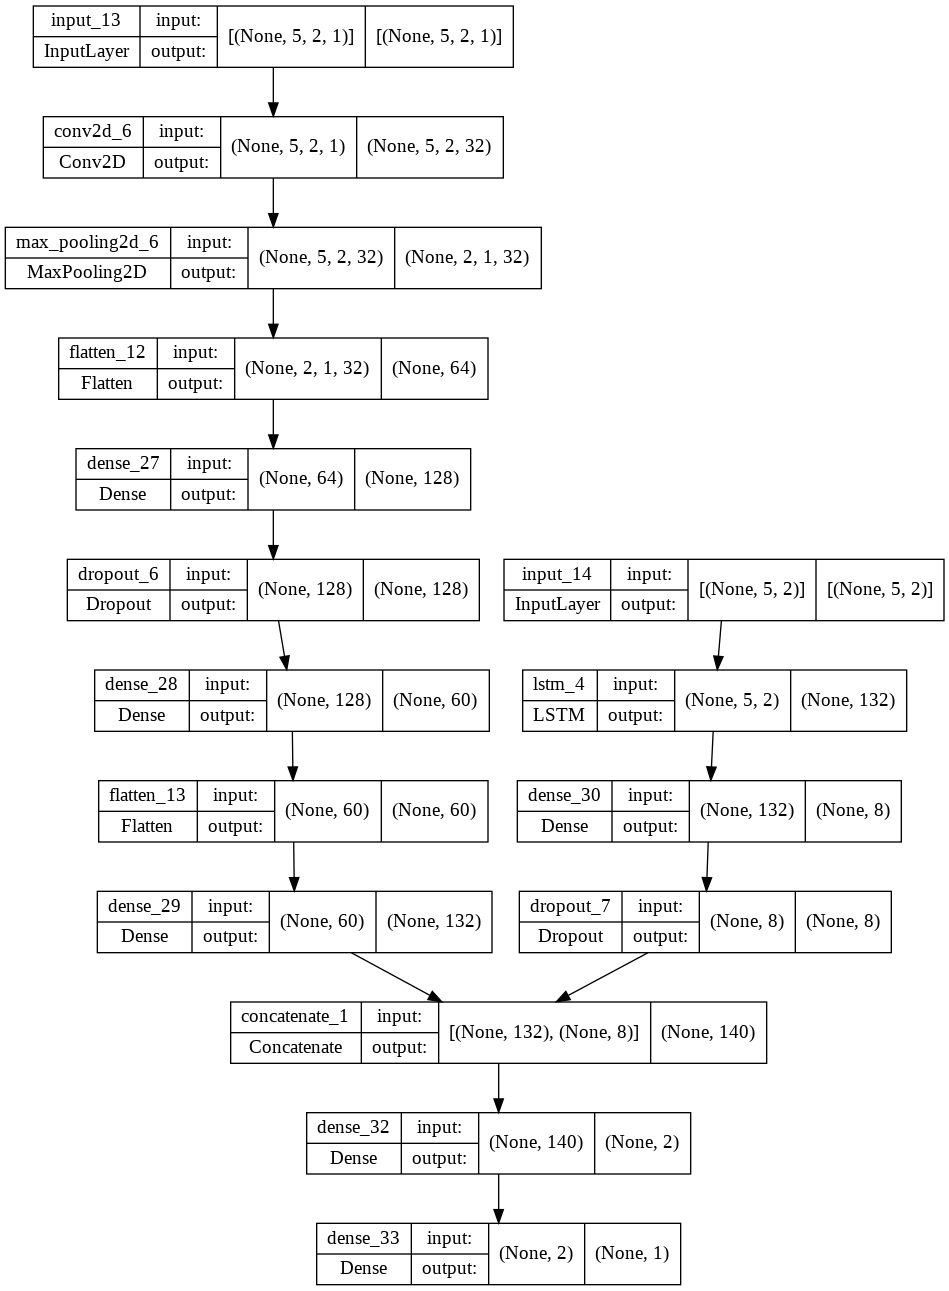

In [34]:
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
plot_model(model, to_file='Functional CNN LSTM 1D.png', show_shapes=True,show_layer_names=True)

In [35]:
## Reshape X_train and X_test to extract inputB
X_train2=tf.reshape(X_train, [302802,5,2])
X_test2=tf.reshape(X_test, [75701,5,2])

In [36]:
## Compile and Fit
model.compile(optimizer='adam', loss='mse')
model.fit(x=[X_train, X_train2], y=[y_train], epochs=30, verbose=2, validation_data=([X_test, X_test2], [y_test]))

Epoch 1/30
9463/9463 - 74s - loss: 0.0259 - val_loss: 8.5093e-04 - 74s/epoch - 8ms/step
Epoch 2/30
9463/9463 - 71s - loss: 6.8451e-04 - val_loss: 5.9870e-04 - 71s/epoch - 8ms/step
Epoch 3/30
9463/9463 - 71s - loss: 5.7562e-04 - val_loss: 4.1022e-04 - 71s/epoch - 8ms/step
Epoch 4/30
9463/9463 - 70s - loss: 5.2832e-04 - val_loss: 0.0016 - 70s/epoch - 7ms/step
Epoch 5/30
9463/9463 - 72s - loss: 5.1637e-04 - val_loss: 3.6771e-04 - 72s/epoch - 8ms/step
Epoch 6/30
9463/9463 - 71s - loss: 4.9474e-04 - val_loss: 4.5779e-04 - 71s/epoch - 8ms/step
Epoch 7/30
9463/9463 - 71s - loss: 4.8031e-04 - val_loss: 3.5757e-04 - 71s/epoch - 8ms/step
Epoch 8/30
9463/9463 - 71s - loss: 4.6211e-04 - val_loss: 4.6191e-04 - 71s/epoch - 8ms/step
Epoch 9/30
9463/9463 - 71s - loss: 4.5180e-04 - val_loss: 5.0100e-04 - 71s/epoch - 8ms/step
Epoch 10/30
9463/9463 - 73s - loss: 4.3136e-04 - val_loss: 3.7853e-04 - 73s/epoch - 8ms/step
Epoch 11/30
9463/9463 - 71s - loss: 4.2361e-04 - val_loss: 3.0862e-04 - 71s/epoch - 7ms

In [37]:
import sklearn.metrics
pred= model.predict(x=[X_test, X_test2])

rmse = mean_squared_error(y_test, pred, squared=False)
print("Root Mean Square:" ,round(rmse,2))

Root Mean Square: 0.02


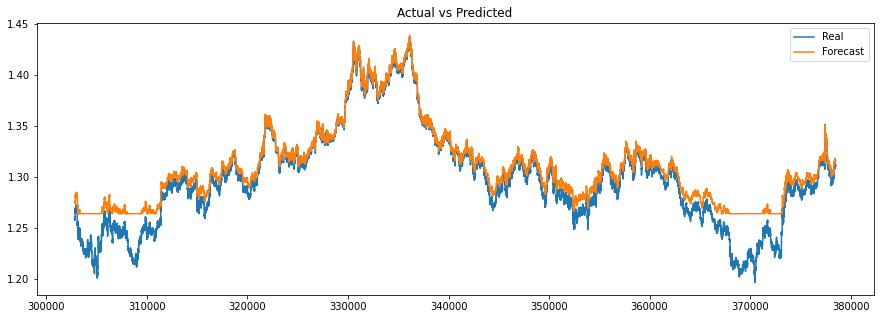

In [38]:
plt.figure(figsize=(15,5))
plt.plot(range(history,history+len(pred)),y_test,label='Real')
plt.plot(range(history,history+len(pred)),pred,label='Forecast')
plt.title('Actual vs Predicted')
plt.legend(loc='best')
plt.show()